Fitting 3 folds for each of 18 candidates, totalling 54 fits
✅ Best XGBoost Parameters: {'learning_rate': 0.2, 'max_depth': 3, 'scale_pos_weight': 1}

=== 🌲 Random Forest ===
🔎 Accuracy: 0.9153
              precision    recall  f1-score   support

           0     0.8571    0.8000    0.8276        15
           1     0.9333    0.9545    0.9438        44

    accuracy                         0.9153        59
   macro avg     0.8952    0.8773    0.8857        59
weighted avg     0.9140    0.9153    0.9143        59



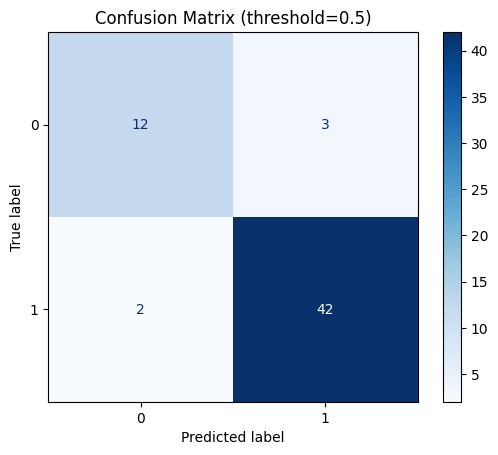

=== 🚀 Tuned XGBoost ===
🔎 Accuracy: 0.9153
              precision    recall  f1-score   support

           0     0.9167    0.7333    0.8148        15
           1     0.9149    0.9773    0.9451        44

    accuracy                         0.9153        59
   macro avg     0.9158    0.8553    0.8799        59
weighted avg     0.9153    0.9153    0.9119        59



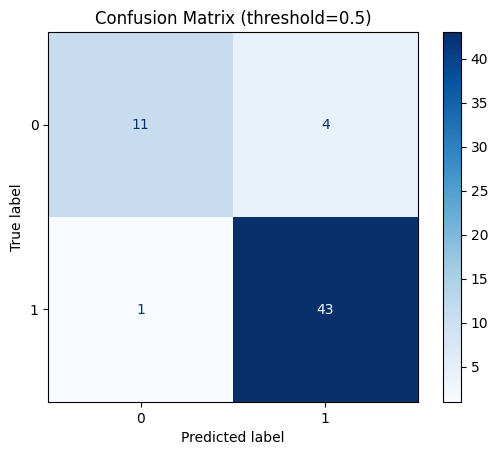

🎯 Best threshold for max F1: 0.3372

=== 🚀 XGBoost at Optimal Threshold = 0.3372 ===
🔎 Accuracy: 0.9322
              precision    recall  f1-score   support

           0     1.0000    0.7333    0.8462        15
           1     0.9167    1.0000    0.9565        44

    accuracy                         0.9322        59
   macro avg     0.9583    0.8667    0.9013        59
weighted avg     0.9379    0.9322    0.9285        59



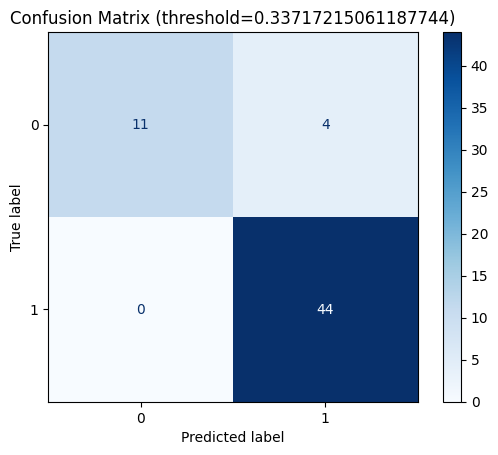

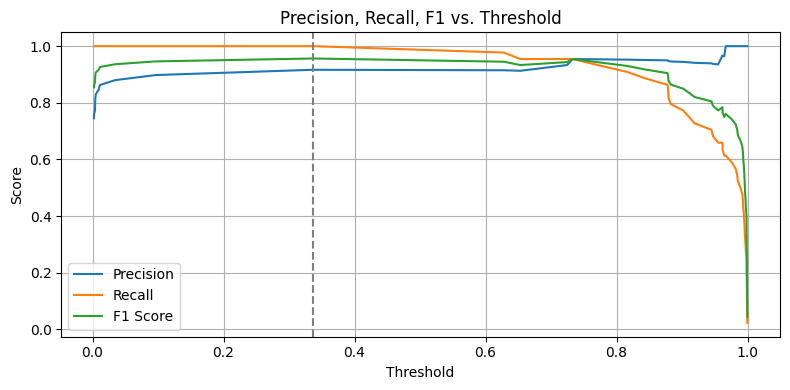

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import (
    accuracy_score, classification_report, ConfusionMatrixDisplay,
    precision_recall_curve, f1_score
)

# 1. Load Parkinson's dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/parkinsons/parkinsons.data"
df = pd.read_csv(url)
df.drop(columns=['name'], inplace=True)  # Drop identifier column
X = df.drop('status', axis=1)
y = df['status']  # 1 = Parkinson's, 0 = Healthy

# 2. Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3,
                                                  stratify=y, random_state=42)

# 3. SMOTE to balance classes in training data
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

# 4. Define models
rf = RandomForestClassifier(random_state=42)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# 5. Grid search to tune XGBoost
param_grid = {
    'scale_pos_weight': [1, y_train.value_counts()[0] / y_train.value_counts()[1]],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}
grid = GridSearchCV(xgb, param_grid, scoring='f1', cv=3, n_jobs=-1, verbose=1)
grid.fit(X_res, y_res)
best_xgb = grid.best_estimator_
print("✅ Best XGBoost Parameters:", grid.best_params_)
print()

# 6. Train models
rf.fit(X_res, y_res)
best_xgb.fit(X_res, y_res)

# 7. Evaluation function
def evaluate_model(model, Xv, yv, threshold=0.5):
    if hasattr(model, "predict_proba"):
        probs = model.predict_proba(Xv)[:, 1]
        preds = (probs >= threshold).astype(int)
        return_preds = preds
        return_probs = probs
    else:
        preds = model.predict(Xv)
        return_preds = preds
        return_probs = None

    acc = accuracy_score(yv, preds)
    print(f"🔎 Accuracy: {acc:.4f}")
    print(classification_report(yv, preds, digits=4))
    ConfusionMatrixDisplay.from_predictions(yv, preds, cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix (threshold={threshold})")
    plt.show()

    return return_preds, return_probs

# 8. Evaluate Random Forest
print("=== 🌲 Random Forest ===")
evaluate_model(rf, X_val, y_val)

# 9. Evaluate XGBoost
print("=== 🚀 Tuned XGBoost ===")
y_pred_xgb, y_prob_xgb = evaluate_model(best_xgb, X_val, y_val)

# 10. Threshold tuning for best F1
precision, recall, thresholds = precision_recall_curve(y_val, y_prob_xgb)
f1_scores = 2 * precision * recall / (precision + recall + 1e-8)
opt_idx = np.argmax(f1_scores)
opt_thresh = thresholds[opt_idx]
print(f"🎯 Best threshold for max F1: {opt_thresh:.4f}\n")

# 11. Evaluate XGBoost with optimal threshold
print(f"=== 🚀 XGBoost at Optimal Threshold = {opt_thresh:.4f} ===")
evaluate_model(best_xgb, X_val, y_val, threshold=opt_thresh)

# 12. Plot Precision, Recall, F1 vs. Threshold
plt.figure(figsize=(8, 4))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.plot(thresholds, f1_scores[:-1], label='F1 Score')
plt.axvline(opt_thresh, linestyle='--', color='gray')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, F1 vs. Threshold')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()
